In [1]:
import cudf, cuml

In [2]:
%%time
# LOAD TRAIN
data = cudf.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
# LOAD TEST
# test_data = cudf.read_csv('../input/ieee-fraud-detection/test_transaction.csv')

CPU times: user 740 ms, sys: 525 ms, total: 1.27 s
Wall time: 1.26 s


In [3]:
print(data.columns.to_list())
print(data['isFraud'].value_counts())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [4]:
data.columns
data.drop(['ProductCD', 'P_emaildomain', 'R_emaildomain'], inplace=True, axis=1)

In [5]:
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
print(categorical_cols)
# for col in categorical_cols:
#     print(data[col].value_counts(normalize=True))

['card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [6]:
from cuml.preprocessing import LabelEncoder
encoders = dict()
for col_name in categorical_cols:
    series = data[col_name]
    label_encoder = LabelEncoder()
    data[col_name] = cudf.Series(
        label_encoder.fit_transform(data[col_name].fillna('None')),
        )
    encoders[col_name] = label_encoder
    print(col_name)
    print(label_encoder.classes_)

card4
[
  "None",
  "american express",
  "discover",
  "mastercard",
  "visa"
]
dtype: object
card6
[
  "None",
  "charge card",
  "credit",
  "debit",
  "debit or credit"
]
dtype: object
M1
[
  "F",
  "None",
  "T"
]
dtype: object
M2
[
  "F",
  "None",
  "T"
]
dtype: object
M3
[
  "F",
  "None",
  "T"
]
dtype: object
M4
[
  "M0",
  "M1",
  "M2",
  "None"
]
dtype: object
M5
[
  "F",
  "None",
  "T"
]
dtype: object
M6
[
  "F",
  "None",
  "T"
]
dtype: object
M7
[
  "F",
  "None",
  "T"
]
dtype: object
M8
[
  "F",
  "None",
  "T"
]
dtype: object
M9
[
  "F",
  "None",
  "T"
]
dtype: object


In [7]:
import xgboost as xgb

In [8]:
from cuml.model_selection import StratifiedKFold
from cuml.metrics import roc_auc_score
import pandas as pd

In [9]:
import shap
import seaborn as sns

# Stratified K-Fold and parameters setup
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=175)
auc_scores = []
shap_values_df = pd.DataFrame()
params = {"device": "cuda"}

# Loop through each fold
for fold, (trn_idx, val_idx) in enumerate(
    skf.split(data.drop(['isFraud'], axis=1), data['isFraud'])
):
    print(f"fold {fold}")
    X_train, y_train = data.drop(['isFraud'], axis=1).iloc[trn_idx], data['isFraud'].iloc[trn_idx]
    X_val, y_val = data.drop(['isFraud'], axis=1).iloc[val_idx], data['isFraud'].iloc[val_idx]
    
    # Train model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    # Evaluate model
    auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    auc_scores.append(auc_score)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    
    # Accumulate SHAP values
    fold_shap_df = pd.DataFrame(shap_values, columns=X_val.columns)
    fold_shap_df["fold"] = fold
    shap_values_df = pd.concat([shap_values_df, fold_shap_df], axis=0)

print("AUC scores:", auc_scores)

fold 0


Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


fold 1


Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


AUC scores: [0.9361503720283508, 0.9346901774406433]


In [10]:
print(len(X_val))

295269


In [11]:
data['card4'].value_counts(dropna=False)

card4
4    384767
3    189217
1      8328
2      6651
0      1577
Name: count, dtype: int64

In [14]:
#load test data
test_data = cudf.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [15]:
test_data.drop(['ProductCD', 'P_emaildomain', 'R_emaildomain'], inplace=True, axis=1)
print(test_data.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=390)


In [16]:
for col_name in categorical_cols:
    print(col_name)
    classes = encoders[col_name].classes_
    vals = list(test_data[col_name].value_counts(normalize=True, dropna=False).to_dict().keys())
#     print(vals)
#     print([(val, val in classes) for val in vals])
    try:
        test_data[col_name] = cudf.Series(
            encoders[col_name].transform(test_data[col_name].fillna('None')),
            )
    except:
        print(test_data[col_name].fillna('None').value_counts(normalize=True))
        print(classes)



card4
card6
M1
M2
M3
M4
M5
M6
M7
M8
M9


In [17]:
print(test_data.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=390)


In [27]:
model.classes_

array([0, 1])

In [30]:
#generate predictions for test
probabilities = model.predict_proba(test_data)
print(probabilities)
submission = cudf.DataFrame(cudf.Series(test_data['TransactionID']))
submission['isFraud'] = cudf.Series(probabilities[:, 1])
submission.to_csv('submission.csv', index=False)

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


[[0.9777681  0.0222319 ]
 [0.99303603 0.00696395]
 [0.9958395  0.00416052]
 ...
 [0.9928204  0.0071796 ]
 [0.98974144 0.01025853]
 [0.989455   0.01054502]]


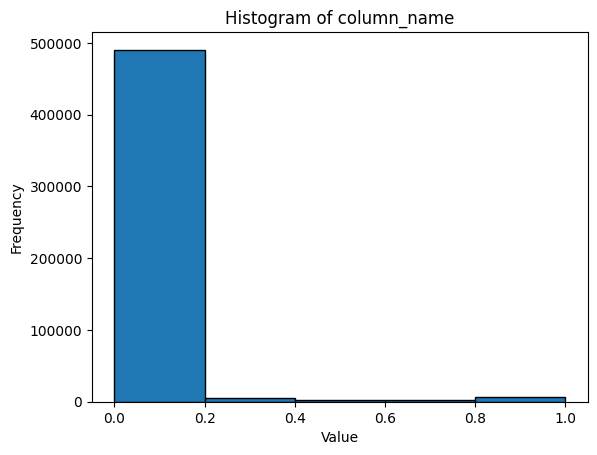

In [28]:
import matplotlib.pyplot as plt
plt.hist(submission['isFraud'], bins=5, edgecolor='black')
plt.title('Histogram of column_name')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# explanation = explainer(X_val)
# explanation.shape
# # shap.plots.beeswarm(explanation)

In [ ]:
# shap.plots.beeswarm(explanation)